# Análise e predição de Dados do IMDB

Esse notebook foi feito para o desafio do programa Lighthouse da Indicium. Ele tem como objetivo realizar a análise e predição dos dados recebidos e responder perguntas relacionadas ao conteúdo obtido.



In [61]:
#Imports necessários para a análise e predição dos dados

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from category_encoders.count import CountEncoder
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle
import warnings

warnings.filterwarnings('ignore')

# Limpeza dos Dados

## Análise inicial do dataframe

In [62]:
#importar dataframe

df = pd.read_csv('data/desafio_indicium_imdb.csv')
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [63]:
#Verificar a quantidade de valores nulos no dataset
df.isnull().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [64]:
#Verificar os dtypes das colunas do dataset
df.dtypes

Unnamed: 0         int64
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

In [65]:
#verificar as colunas do dataset 
df.columns

Index(['Unnamed: 0', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime',
       'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1',
       'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

## Começo da limpeza dos dados

Em uma análise rápida dos valores iniciais do Dataframe, a coluna de gênero me chamou a atenção. Cada filme parece conter mais de um gênero na mesma coluna, o que poderia dificultar minha análise no futuro. Aqui tenho a intenção de comprovar essa hipótese e decidir como lidar com a coluna

In [66]:
#Verificar os valores da coluna Genre

df['Genre'].values

array(['Crime, Drama', 'Action, Crime, Drama', 'Crime, Drama',
       'Crime, Drama', 'Action, Adventure, Drama', 'Crime, Drama',
       'Biography, Drama, History', 'Action, Adventure, Sci-Fi', 'Drama',
       'Action, Adventure, Drama', 'Drama, Romance', 'Western',
       'Action, Adventure, Drama', 'Action, Sci-Fi',
       'Biography, Crime, Drama', 'Action, Adventure, Fantasy', 'Drama',
       'Biography, Drama, History', 'Comedy, Drama, Thriller', 'Drama',
       'Adventure, Drama, Sci-Fi', 'Crime, Drama',
       'Animation, Adventure, Family', 'Drama, War',
       'Crime, Drama, Fantasy', 'Comedy, Drama, Romance',
       'Crime, Drama, Mystery', 'Crime, Drama, Thriller',
       'Action, Adventure, Fantasy', 'Action, Drama, Mystery',
       'Action, Adventure, Drama', 'Drama, Family, Fantasy',
       'Crime, Drama, Thriller', 'Drama, Music',
       'Biography, Comedy, Drama', 'Drama, Mystery, Sci-Fi',
       'Crime, Drama, Thriller', 'Biography, Drama, Music',
       'Action, Adve

Como eu suspeitava, a coluna possui mais de um valor por célula e eles se repetem diversas vezes, criando muitos valores únicos. 
Pensando em melhorar a assertividade da minha análise, decidi separar cada gênero único em uma coluna diferente, e usar a técnica de OneHotEncoding para manter a classificação dos dados

In [67]:
#Retirar os espaços depois da vírgula dos gêneros, evitando que existam colunas duplicadas como 'Adventure' e ' Adventure'
df["Genre_list"] = (
    df["Genre"]
    .fillna("")
    .apply(lambda s: [g.strip() for g in s.split(",") if g.strip()])
)

#Separar os valores depois da vírgula em uma coluna diferente
df['Genre'] = df['Genre_list'].str.split(',')

#Usar a nova coluna criada como base para o OneHotEncoding
genre_dummies = df['Genre_list'].explode().str.get_dummies().groupby(level=0).sum()

#Aplicar as alterações do dataframe em uma nova variável, que será utilizada para a análise dos dados
df_analise = df.join(genre_dummies)

#Excluir a coluna 'Genre', que agora é obsoleta
df_analise = df_analise.drop(labels = 'Genre',axis=1)

#Verificar se as alterações foram feitas com sucesso
df_analise.head(5)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,The Godfather,1972,A,175 min,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,...,0,0,0,0,0,0,0,0,0,0
1,2,The Dark Knight,2008,UA,152 min,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,...,0,0,0,0,0,0,0,0,0,0
2,3,The Godfather: Part II,1974,A,202 min,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,...,0,0,0,0,0,0,0,0,0,0
3,4,12 Angry Men,1957,U,96 min,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,...,0,0,0,0,0,0,0,0,0,0
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,...,0,0,0,0,0,0,0,0,0,0


### Ajustes nos dtype dos dados

In [68]:
#Verificar os valores da coluna Certificate, incluindo os nulos
df_analise['Certificate'].value_counts(dropna= False)


Certificate
U           234
A           196
UA          175
R           146
NaN         101
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

Esse resultado nos diz algumas coisas:

1. O dataframe utiliza mais de um padrão de classificação indicativa. Enquanto 'PG-13' e 'PG' representam o sistema de classificação indicativa dos Estados Unidos, por exemplo, 'U' e 'A' fazem parte do sistema de classificação indicativa da Índia.
2. A maior parte dos dados está utilizando o sistema indiano de classificação indicativa.
3. Temos uma quantidade considerável de valores nulos, praticamente 10% do dataset.

Levantei a hipótese de que os valores nulos poderiam estar relacionados a data de lançamento dos filmes, como filmes antigos que não tivessem classificação etária ou a informação se perdeu com o tempo, mas ao tentar criar um filtro com 'df_analise[df_analise['Released_Year']< 1940]' me dei conta de que, apesar de ser um dado numérico, a coluna de ano de lançamento usa dados do tipo string.

Devo tratar isso para descobrir se minha hipótese é verdadeira.

In [69]:
#Verificando os valores únicos da coluna Released Year
df_analise['Released_Year'].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2020',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2011', '2006', '2000', '1988', '1985', '1968',
       '1960', '1942', '1936', '1931', '2018', '2017', '2016', '2012',
       '2009', '2007', '1984', '1981', '1979', '1971', '1963', '1964',
       '1950', '1940', '2013', '2005', '2004', '1992', '1987', '1986',
       '1983', '1976', '1973', '1965', '1959', '1958', '1952', '1948',
       '1944', '1941', '1927', '1921', '2015', '1996', '1989', '1978',
       '1961', '1955', '1953', '1925', '1924', '1982', '1967', '1951',
       '1949', '1939', '1937', '1934', '1928', '1926', '1920', '1970',
       '1969', '1956', '1947', '1945', '1930', '1938', '1935', '1933',
       '1932', '1922', '1943', 'PG'], dtype=object)

Esse resultado nos trouxe outro dado interessante: nem todos os valores presentes na coluna 'Released_Year' são numéricos. É seguro assumir que o valor 'PG' foi preenchido acidentalmente e pertence à coluna 'Certificate', já que é uma classificação indicativa. Preciamos tratar esse valor antes de transformar os valores dessa coluna.

In [70]:
#Verificar quais dados são afetados pelo valor 'PG' em Released_Year
df_analise[df_analise['Released_Year']== 'PG']

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
965,966,Apollo 13,PG,U,140 min,7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,...,0,0,0,0,0,0,0,0,0,0


Apenas o filme Apollo 13 possui o valor 'PG' na coluna Released_Year, o que aumenta a confiança na hipótese de que o valor foi preenchido acidentalmente.

Como é um único dado e essa é uma informação fácil de se encontrar, pesquisei pela data de lançamento do filme para substituir 'PG' pelo valor correto.

In [71]:
#Substituir 'PG' na coluna Released_Year por 1955, o ano de lançamento de Apollo 13
df_analise.loc[df_analise['Released_Year'] == 'PG', 'Released_Year'] = '1955'

#Transformar os valores de Released_Year em int
df_analise['Released_Year'] = df_analise['Released_Year'].astype(int)

#Verificar se as alterações foram feitas
df_analise['Released_Year'].unique()

array([1972, 2008, 1974, 1957, 2003, 1994, 1993, 2010, 1999, 2001, 1966,
       2002, 1990, 1980, 1975, 2020, 2019, 2014, 1998, 1997, 1995, 1991,
       1977, 1962, 1954, 1946, 2011, 2006, 2000, 1988, 1985, 1968, 1960,
       1942, 1936, 1931, 2018, 2017, 2016, 2012, 2009, 2007, 1984, 1981,
       1979, 1971, 1963, 1964, 1950, 1940, 2013, 2005, 2004, 1992, 1987,
       1986, 1983, 1976, 1973, 1965, 1959, 1958, 1952, 1948, 1944, 1941,
       1927, 1921, 2015, 1996, 1989, 1978, 1961, 1955, 1953, 1925, 1924,
       1982, 1967, 1951, 1949, 1939, 1937, 1934, 1928, 1926, 1920, 1970,
       1969, 1956, 1947, 1945, 1930, 1938, 1935, 1933, 1932, 1922, 1943])

In [72]:
df_analise['Runtime'].unique()

array(['175 min', '152 min', '202 min', '96 min', '201 min', '154 min',
       '195 min', '148 min', '139 min', '178 min', '142 min', '161 min',
       '179 min', '136 min', '146 min', '124 min', '133 min', '160 min',
       '132 min', '153 min', '169 min', '130 min', '125 min', '189 min',
       '116 min', '127 min', '118 min', '121 min', '207 min', '122 min',
       '106 min', '112 min', '151 min', '150 min', '155 min', '119 min',
       '110 min', '88 min', '137 min', '89 min', '165 min', '109 min',
       '102 min', '87 min', '126 min', '147 min', '117 min', '181 min',
       '149 min', '105 min', '164 min', '170 min', '98 min', '101 min',
       '113 min', '134 min', '229 min', '115 min', '143 min', '95 min',
       '104 min', '123 min', '131 min', '108 min', '81 min', '99 min',
       '114 min', '129 min', '228 min', '128 min', '103 min', '107 min',
       '68 min', '138 min', '156 min', '167 min', '163 min', '186 min',
       '321 min', '135 min', '140 min', '180 min', '158 min'

Similar à coluna Relesed_Year, Runtime também guarda seus valores como string, mas eles poderiam ser transformados em valores numéricos para facilitar a análise

In [73]:
#Retirar 'min' dos valores, já que todos eles estão em minutos, e declarar essa informação no título da coluna, além de converter os valores para inteiros
df_analise['Runtime_min'] = df_analise['Runtime'].str.replace(' min', '', regex=False).astype(int)

df_analise['Runtime_min'].unique()

array([175, 152, 202,  96, 201, 154, 195, 148, 139, 178, 142, 161, 179,
       136, 146, 124, 133, 160, 132, 153, 169, 130, 125, 189, 116, 127,
       118, 121, 207, 122, 106, 112, 151, 150, 155, 119, 110,  88, 137,
        89, 165, 109, 102,  87, 126, 147, 117, 181, 149, 105, 164, 170,
        98, 101, 113, 134, 229, 115, 143,  95, 104, 123, 131, 108,  81,
        99, 114, 129, 228, 128, 103, 107,  68, 138, 156, 167, 163, 186,
       321, 135, 140, 180, 158, 210,  86, 162, 177, 204,  91, 172,  45,
       145, 100, 196,  93, 120,  92, 144,  80, 183, 111, 141, 224, 171,
       188,  94, 185,  85, 205, 212, 238,  72,  67,  76, 159,  83,  90,
        84, 191, 197, 174,  97,  75, 157, 209,  82, 220,  64, 184, 168,
       166, 192, 194, 193,  69,  70, 242,  79,  71,  78])

### Tratando valores nulos

Agora que os valores estão padronizados, posso verificar se consigo identificar algum padrão nos valores nulos presentes em 'Certificate'

In [74]:
df[df['Certificate'].isna()]

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Genre_list
29,30,Seppuku,1962,NaN,133 min,NaN,8.6,When a ronin requesting seppuku at a feudal lo...,85.0,Masaki Kobayashi,Tatsuya Nakadai,Akira Ishihama,Shima Iwashita,Tetsurô Tanba,42004,NaN,"[Action, Drama, Mystery]"
53,54,Ayla: The Daughter of War,2017,NaN,125 min,NaN,8.4,"In 1950, amid-st the ravages of the Korean War...",NaN,Can Ulkay,Erdem Can,Çetin Tekindor,Ismail Hacioglu,Kyung-jin Lee,34112,NaN,"[Biography, Drama, History]"
76,77,Tengoku to jigoku,1963,NaN,143 min,NaN,8.4,An executive of a shoe company becomes a victi...,NaN,Akira Kurosawa,Toshirô Mifune,Yutaka Sada,Tatsuya Nakadai,Kyôko Kagawa,34357,NaN,"[Crime, Drama, Mystery]"
91,92,Babam ve Oglum,2005,NaN,112 min,NaN,8.3,The family of a left-wing journalist is torn a...,NaN,Çagan Irmak,Çetin Tekindor,Fikret Kuskan,Hümeyra,Ege Tanman,78925,NaN,"[Drama, Family]"
120,121,Ikiru,1952,NaN,143 min,NaN,8.3,A bureaucrat tries to find a meaning in his li...,NaN,Akira Kurosawa,Takashi Shimura,Nobuo Kaneko,Shin'ichi Himori,Haruo Tanaka,68463,"55,240",[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,920,The Secret of Kells,2009,NaN,71 min,NaN,7.6,A young boy in a remote medieval outpost under...,81.0,Tomm Moore,Nora Twomey,Evan McGuire,Brendan Gleeson,Mick Lally,31779,"686,383","[Animation, Adventure, Family]"
925,926,Dead Man's Shoes,2004,NaN,90 min,NaN,7.6,A disaffected soldier returns to his hometown ...,52.0,Shane Meadows,Paddy Considine,Gary Stretch,Toby Kebbell,Stuart Wolfenden,49728,"6,013","[Crime, Drama, Thriller]"
943,944,Batoru rowaiaru,2000,NaN,114 min,NaN,7.6,"In the future, the Japanese government capture...",81.0,Kinji Fukasaku,Tatsuya Fujiwara,Aki Maeda,Tarô Yamamoto,Takeshi Kitano,169091,NaN,"[Action, Adventure, Drama]"
997,998,Lifeboat,1944,NaN,97 min,NaN,7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,26471,NaN,"[Drama, War]"


In [75]:
df_analise[df_analise['Released_Year'] < 1940]

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Runtime_min
50,51,Modern Times,1936,G,87 min,8.5,The Tramp struggles to live in modern industri...,96.0,Charles Chaplin,Charles Chaplin,...,0,0,0,0,0,0,0,0,0,87
51,52,City Lights,1931,G,87 min,8.5,"With the aid of a wealthy erratic tippler, a d...",99.0,Charles Chaplin,Charles Chaplin,...,0,0,0,1,0,0,0,0,0,87
124,125,M - Eine Stadt sucht einen Mörder,1931,Passed,117 min,8.3,When the police in a German city are unable to...,NaN,Fritz Lang,Peter Lorre,...,0,0,1,0,0,0,1,0,0,117
125,126,Metropolis,1927,NaN,153 min,8.3,In a futuristic city sharply divided between t...,98.0,Fritz Lang,Brigitte Helm,...,0,0,0,0,1,0,0,0,0,153
126,127,The Kid,1921,Passed,68 min,8.3,"The Tramp cares for an abandoned child, but ev...",NaN,Charles Chaplin,Charles Chaplin,...,0,0,0,0,0,0,0,0,0,68
192,193,The Gold Rush,1925,Passed,95 min,8.2,A prospector goes to the Klondike in search of...,NaN,Charles Chaplin,Charles Chaplin,...,0,0,0,0,0,0,0,0,0,95
193,194,Sherlock Jr.,1924,Passed,45 min,8.2,"A film projectionist longs to be a detective, ...",NaN,Buster Keaton,Buster Keaton,...,0,0,0,1,0,0,0,0,0,45
312,313,Mr. Smith Goes to Washington,1939,Passed,129 min,8.1,A naive man is appointed to fill a vacancy in ...,73.0,Frank Capra,James Stewart,...,0,0,0,0,0,0,0,0,0,129
313,314,Gone with the Wind,1939,U,238 min,8.1,A manipulative woman and a roguish man conduct...,97.0,Victor Fleming,George Cukor,...,0,0,0,1,0,0,0,0,0,238
314,315,La Grande Illusion,1937,NaN,113 min,8.1,"During WWI, two French soldiers are captured a...",NaN,Jean Renoir,Jean Gabin,...,0,0,0,0,0,0,0,1,0,113


Os valores nulos da coluna não parecem a estar atrelados a nenhum padrão confiável ou intuitivo, portanto temos que pensar em como lidar com eles.
Dentro dos valores de Certificate, já existe um valor 'Unrated'. Como não sabemos a classificação indicativa dos filmes com valores nulos, vamos marcá-los como 'Unrated'.

In [76]:
df_analise['Certificate'] = df_analise['Certificate'].fillna('Unrated')
df_analise.isnull().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate        0
Runtime            0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
Genre_list         0
Action             0
Adventure          0
Animation          0
Biography          0
Comedy             0
Crime              0
Drama              0
Family             0
Fantasy            0
Film-Noir          0
History            0
Horror             0
Music              0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Sport              0
Thriller           0
War                0
Western            0
Runtime_min        0
dtype: int64

In [77]:
df_analise.head(10)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,...,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Runtime_min
0,1,The Godfather,1972,A,175 min,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,...,0,0,0,0,0,0,0,0,0,175
1,2,The Dark Knight,2008,UA,152 min,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,...,0,0,0,0,0,0,0,0,0,152
2,3,The Godfather: Part II,1974,A,202 min,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,...,0,0,0,0,0,0,0,0,0,202
3,4,12 Angry Men,1957,U,96 min,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,...,0,0,0,0,0,0,0,0,0,96
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,...,0,0,0,0,0,0,0,0,0,201
5,6,Pulp Fiction,1994,A,154 min,8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,...,0,0,0,0,0,0,0,0,0,154
6,7,Schindler's List,1993,A,195 min,8.9,"In German-occupied Poland during World War II,...",94.0,Steven Spielberg,Liam Neeson,...,0,0,0,0,0,0,0,0,0,195
7,8,Inception,2010,UA,148 min,8.8,A thief who steals corporate secrets through t...,74.0,Christopher Nolan,Leonardo DiCaprio,...,0,0,0,0,1,0,0,0,0,148
8,9,Fight Club,1999,A,139 min,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,...,0,0,0,0,0,0,0,0,0,139
9,10,The Lord of the Rings: The Fellowship of the Ring,2001,U,178 min,8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,...,0,0,0,0,0,0,0,0,0,178


Ainda existem alguns valores únicos em Certificate que podemos tratar e padronizar

In [78]:
df_analise.loc[df_analise['Certificate'] == 'U/A', 'Certificate'] = 'UA'
df_analise['Certificate'].value_counts()

Certificate
U           234
A           196
UA          176
R           146
Unrated     102
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Name: count, dtype: int64

In [79]:
#Fazer OneHotEncoding com Certificate

certificate_dummies = df_analise['Certificate'].str.get_dummies()
df_analise = df_analise.join(certificate_dummies)

df_analise

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,...,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,UA,Unrated
0,1,The Godfather,1972,A,175 min,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,...,0,0,0,0,0,0,0,0,0,0
1,2,The Dark Knight,2008,UA,152 min,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,...,0,0,0,0,0,0,0,0,1,0
2,3,The Godfather: Part II,1974,A,202 min,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,...,0,0,0,0,0,0,0,0,0,0
3,4,12 Angry Men,1957,U,96 min,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,...,0,0,0,0,0,0,0,1,0,0
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,Breakfast at Tiffany's,1961,A,115 min,7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,...,0,0,0,0,0,0,0,0,0,0
995,996,Giant,1956,G,201 min,7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,...,0,0,0,0,0,0,0,0,0,0
996,997,From Here to Eternity,1953,Passed,118 min,7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,...,0,0,1,0,0,0,0,0,0,0
997,998,Lifeboat,1944,Unrated,97 min,7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,...,0,0,0,0,0,0,0,0,0,1


Agora vamos tratar os nulos da coluna Meta_Score. Eles já são valores numéricos e estão inputados como float. Para essa métrica, irei substituir os nulos pela média dos valores da coluna. Escolhi a média pois os valores do Meta_Score não são muito discrepantes entre si, portanto a média é uma boa representação numérica.

In [80]:
df_analise['Meta_score'] = df_analise['Meta_score'].fillna(df_analise['Meta_score'].mean())
df_analise.isnull().sum()

Unnamed: 0         0
Series_Title       0
Released_Year      0
Certificate        0
Runtime            0
IMDB_Rating        0
Overview           0
Meta_score         0
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
Genre_list         0
Action             0
Adventure          0
Animation          0
Biography          0
Comedy             0
Crime              0
Drama              0
Family             0
Fantasy            0
Film-Noir          0
History            0
Horror             0
Music              0
Musical            0
Mystery            0
Romance            0
Sci-Fi             0
Sport              0
Thriller           0
War                0
Western            0
Runtime_min        0
16                 0
A                  0
Approved           0
G                  0
GP                 0
PG                 0
PG-13              0
Passed             0
R                  0
TV-14        

Por fim, vamos tratar dos nulos da coluna Gross.

In [81]:
#Converter os valores de Gross de string para float

df_analise['Gross'] = df_analise['Gross'].str.replace(',', '', regex=False).astype(float)

In [82]:
#Identificação de outliers na coluna Gross. Por ser uma coluna com valores muito altos, é possível que existam valores outliers que atrapalhem a análise

gross_media = df_analise['Gross'].mean()
gross_std = df_analise['Gross'].std()

limite_inferior = gross_media - 3*gross_std
limite_superior = gross_media + 3*gross_std

outliers = df_analise[(df_analise['Gross'] < limite_inferior) | (df_analise['Gross'] > limite_superior)]

outliers['Gross']

1      534858444.0
42     422783777.0
58     858373000.0
59     678815482.0
62     448139099.0
150    415004880.0
261    402453882.0
356    623279547.0
476    936662225.0
581    532177324.0
582    408084349.0
595    434038008.0
622    760507625.0
651    659325379.0
687    435110554.0
890    608581744.0
Name: Gross, dtype: float64

Text(0.5, 1.0, 'Original')

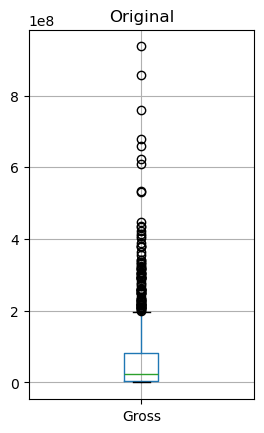

In [83]:
#Visualização dos dados de Gross com outliers em um boxplot

plt.subplot(1,2,1)
df_analise[['Gross']].boxplot()
plt.title("Original")

In [84]:
#Tratamento dos valores outliers com Winsorization

df_analise['Gross'] = np.where(df_analise['Gross'] > limite_superior, limite_superior,
                                       np.where(df_analise['Gross'] < limite_inferior, limite_inferior, df_analise['Gross']))

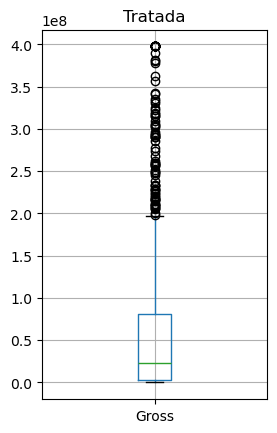

In [85]:
#Visualização dos dados de Gross depois do tratamento de outliers em um boxplot

plt.subplot(1,2,2)
df_analise[['Gross']].boxplot()
plt.title("Tratada")

plt.show()

In [86]:
#Definir features
features = ['Released_Year', 'Runtime_min', 'IMDB_Rating', 'Meta_score', 'No_of_Votes']

#Definir o X e y da predição
df_conhecido = df_analise[df_analise['Gross'].notna()]   
df_desconhecido = df_analise[df_analise['Gross'].isna()] 

X = df_conhecido[features]
y = df_conhecido['Gross']

#Criar um modelo preditivo de RandomForest, que costuma trazer resultados melhores que uma árvore de decisões.
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

#Predição dos valores faltantes da coluna Gross
predictions = model.predict(df_desconhecido[features])

#Substituição dos valores nulos por suas predições
df_analise.loc[df_analise['Gross'].isna(), 'Gross'] = predictions

Como já tenho os valores de outras features numéricas, decidi fazer um pequeno modelo preditivo para prever os valores da coluna Gross. Os valores dessa coluna são grandes e muito variados, por isso um modelo preditivo torna o dataset mais assertivo do que uma substituição mais simples pela média ou mediana

In [87]:
df_analise.isnull().sum()

Unnamed: 0       0
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
Genre_list       0
Action           0
Adventure        0
Animation        0
Biography        0
Comedy           0
Crime            0
Drama            0
Family           0
Fantasy          0
Film-Noir        0
History          0
Horror           0
Music            0
Musical          0
Mystery          0
Romance          0
Sci-Fi           0
Sport            0
Thriller         0
War              0
Western          0
Runtime_min      0
16               0
A                0
Approved         0
G                0
GP               0
PG               0
PG-13            0
Passed           0
R                0
TV-14            0
TV-MA            0
TV-PG            0
U                0
UA               0
Unrated     

In [88]:
#Limpeza das colunas Unnamed: 0 (não precisamos dela, já que já temos um índice) e Runtime (que transformamos em Runtime_min)
df_analise = df_analise.drop(['Unnamed: 0', 'Runtime', 'Certificate'], axis=1)
df_analise

,Series_Title,Released_Year,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,...,PG,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,UA,Unrated
0,The Godfather,1972,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,...,0,0,0,0,0,0,0,0,0,0
1,The Dark Knight,2008,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,...,0,0,0,0,0,0,0,0,1,0
2,The Godfather: Part II,1974,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,...,0,0,0,0,0,0,0,0,0,0
3,12 Angry Men,1957,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,...,0,0,0,0,0,0,0,1,0,0
4,The Lord of the Rings: The Return of the King,2003,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,Breakfast at Tiffany's,1961,7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,Audrey Hepburn,George Peppard,Patricia Neal,Buddy Ebsen,...,0,0,0,0,0,0,0,0,0,0
995,Giant,1956,7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,Elizabeth Taylor,Rock Hudson,James Dean,Carroll Baker,...,0,0,0,0,0,0,0,0,0,0
996,From Here to Eternity,1953,7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,Burt Lancaster,Montgomery Clift,Deborah Kerr,Donna Reed,...,0,0,1,0,0,0,0,0,0,0
997,Lifeboat,1944,7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,Tallulah Bankhead,John Hodiak,Walter Slezak,William Bendix,...,0,0,0,0,0,0,0,0,0,1


### Limpeza das colunas categóricas

Limpeza de Stopwords (palavras comuns, repetitivas, que não adicionam significado para a máquina, como 'a', 'as', etc.) e Stemming (reduzir as palavras às suas raízes para manter apenas o significado base).

In [89]:
#Definição das stop words e stemming
stop_words = stopwords.words('english')
stemmer = nltk.SnowballStemmer('english')

#Função para tratar a coluna Overview
def preprocess_data(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

#Salvar o overview tratado em uma nova coluna
df_analise['Overview_clean'] = df['Overview'].apply(preprocess_data)
df_analise.head()

,Series_Title,Released_Year,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,...,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,UA,Unrated,Overview_clean
0,The Godfather,1972,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,...,0,0,0,0,0,0,0,0,0,an organ crime dynasti age patriarch transfer ...
1,The Dark Knight,2008,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,...,0,0,0,0,0,0,0,1,0,when menac known joker wreak havoc chao peopl ...
2,The Godfather: Part II,1974,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,...,0,0,0,0,0,0,0,0,0,the earli life career vito corleon 1920s new y...
3,12 Angry Men,1957,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,...,0,0,0,0,0,0,1,0,0,a juri holdout attempt prevent miscarriag just...
4,The Lord of the Rings: The Return of the King,2003,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,...,0,0,0,0,0,0,1,0,0,gandalf aragorn lead world men sauron armi dra...


## Análise dos Dados

Com os dados tratados e limpos, podemos fazer uma análise exploratória para entendê-los.

In [90]:
#Criando algumas variáveis úteis para facilitar a análise

gross = df_analise['Gross']
imdb = df_analise['IMDB_Rating']
runtime = df_analise['Runtime_min']
meta_score = df_analise['Meta_score']
num_features = ['Released_Year', 'Runtime_min', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']
genre_features = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
              'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
              'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport',
              'Thriller', 'War', 'Western']

In [91]:
#Medindo a correlação de algumas variávels numéricas com o Faturamento dos filmes

imdb_gross_corr = imdb.corr(gross)
meta_gross_corr = meta_score.corr(gross)
runtime_gross_corr = runtime.corr(gross)

print(imdb_gross_corr,
meta_gross_corr,
runtime_gross_corr)

0.08297713745954004 -0.061773315963907165 0.1327094966634048


Com base nessa análise rápida, a maior correlação está entre o tempo do filme e a nota do IMDB. Curiosamente, o Meta Score tem uma correlação inversa com o faturamento.

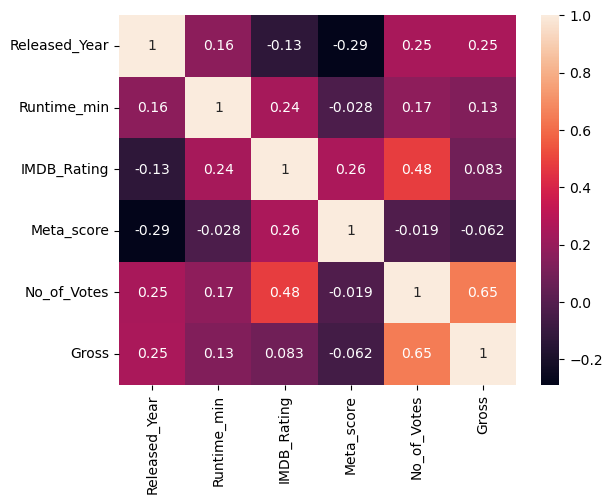

In [92]:
# Podemos visualizar melhor as correlações entre as variáveis numéricas
ax = sns.heatmap(df_analise[num_features].corr(), annot=True)

Com esse gráfico vemos que a maior correlação positiva com o Faturamento é a do número de votos e Ano de Lançamento, o que quer dizer que quanto mais consistente a quantidade de votos que um filme tem, maior a chance de obter um bom faturamento.

In [93]:
genre_corrs = df_analise[genre_features + ['Gross']].corr(method='pearson')['Gross'].sort_values(ascending=False)
print(genre_corrs)

Gross        1.000000
Adventure    0.439378
Action       0.279508
Sci-Fi       0.186652
Animation    0.164482
Fantasy      0.097847
Family       0.071834
Sport       -0.003860
Comedy      -0.005467
Western     -0.016865
Biography   -0.023144
History     -0.028503
Thriller    -0.030598
Horror      -0.049818
Music       -0.053733
Musical     -0.058111
War         -0.062304
Mystery     -0.072434
Film-Noir   -0.079486
Romance     -0.094071
Crime       -0.120520
Drama       -0.317014
Name: Gross, dtype: float64


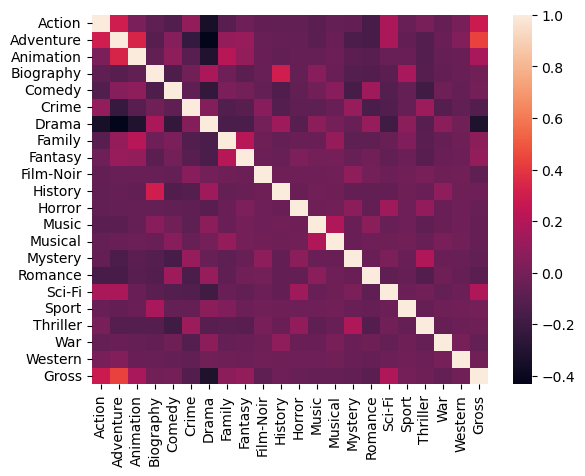

In [94]:
ax_genre = sns.heatmap(df_analise[genre_features + ['Gross']].corr(method='pearson'), annot=False)

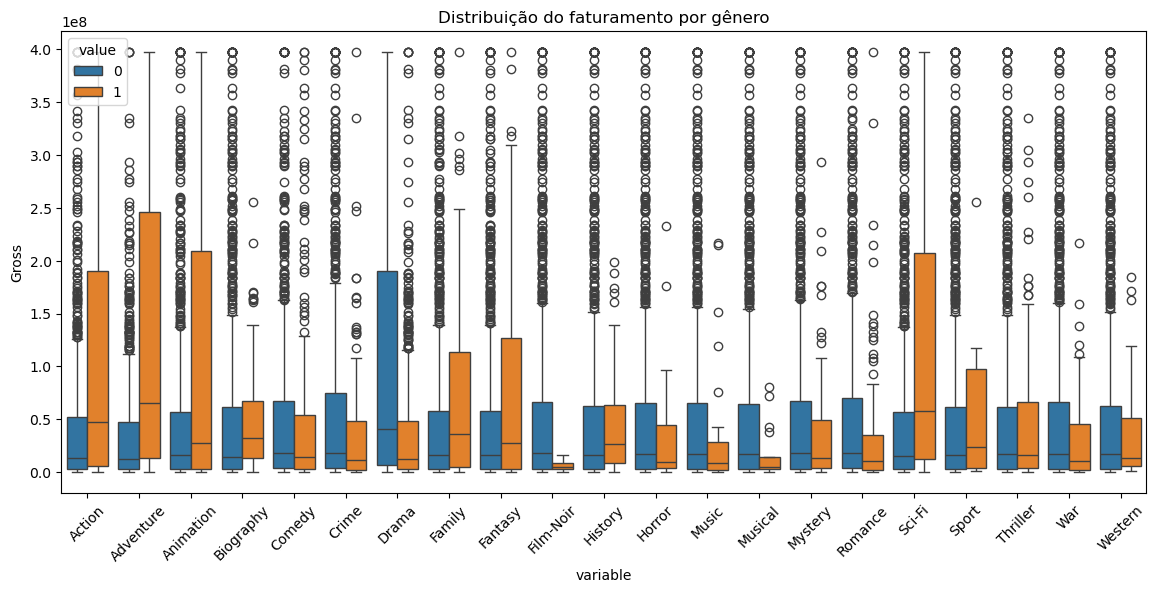

In [95]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_analise.melt(id_vars=['Gross'], value_vars=genre_features),
            x='variable', y='Gross', hue='value')
plt.xticks(rotation=45)
plt.title("Distribuição do faturamento por gênero")
plt.show()

Também medi a correlação entre os gêneros e o faturamento, criando gráficos para uma melhor visualização. Em todos os casos, é possível ver que filmes de Aventura, Ação, Sci-fi e Animação possuem uma correlação positiva maior em relação ao faturamento, enquanto Romance, Crime e Drama possuem uma correlação negativa.

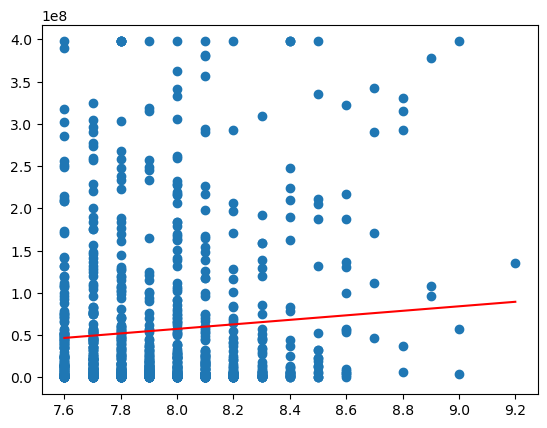

In [96]:
# Gráfico para uma melhor visualização da correlação entre a nota do IMDB e o faturamento do filme.
plt.scatter(imdb, gross)

plt.plot(np.unique(imdb),
np.poly1d(np.polyfit(imdb, gross, 1))
        (np.unique(imdb)), color = 'red')

### Análise dos dados categóricos

Podemos explorar nossos dados categóricos para obter mais insights.

Começamos com uma nuvem de palavras da coluna de Overview, para checar quais são as palavras mais utilizadas.

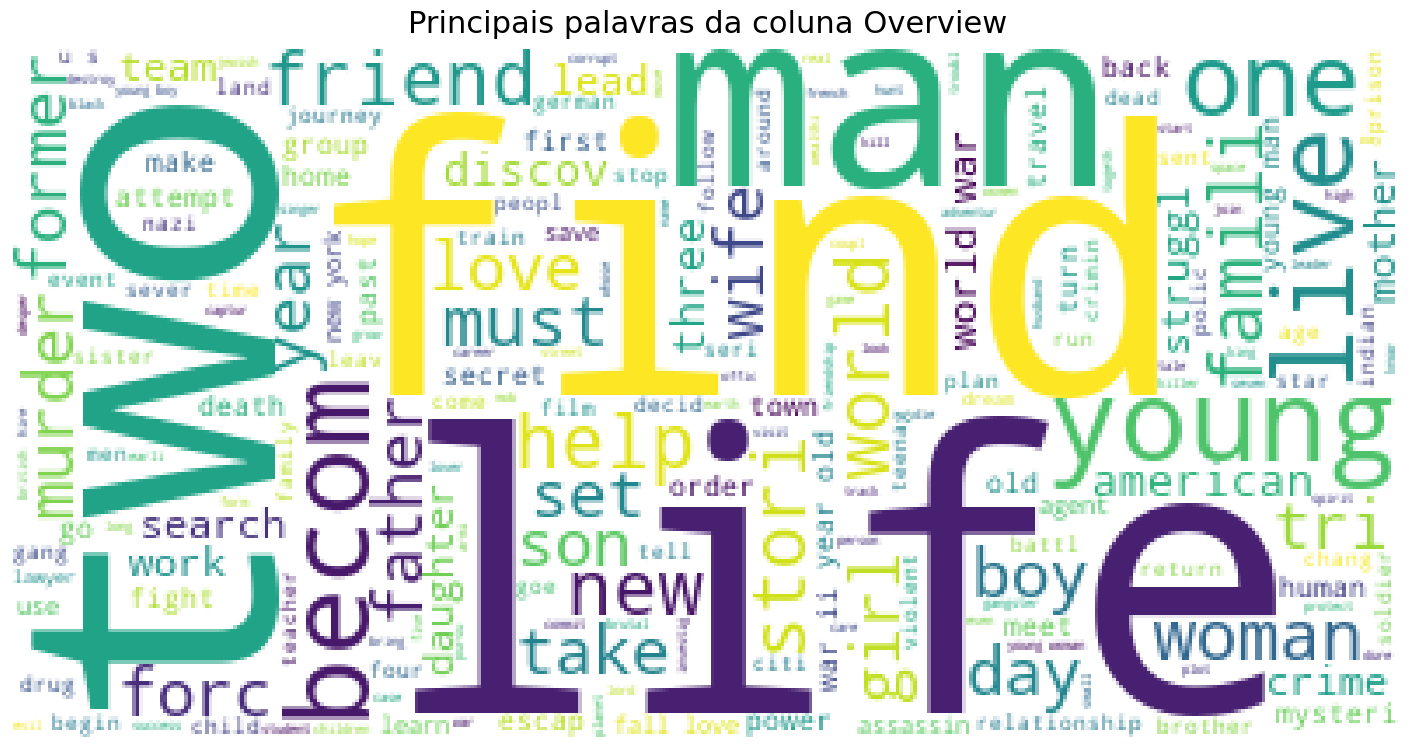

In [97]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)

wc.generate(' '.join(df_analise['Overview_clean']))
plt.figure(figsize=(18,10))
plt.title('Principais palavras da coluna Overview', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Também podemos fazer uma análise simples dos diretores e estrelas que mais aparecem no Dataframe.

In [98]:
df_analise['Director'].value_counts()

Director
Alfred Hitchcock    14
Steven Spielberg    13
Hayao Miyazaki      11
Martin Scorsese     10
Akira Kurosawa      10
                    ..
Kinji Fukasaku       1
Eric Bress           1
Sudha Kongara        1
Thomas Kail          1
Irvin Kershner       1
Name: count, Length: 548, dtype: int64

In [99]:
stars = pd.concat([df_analise['Star1'], df_analise['Star2'], df_analise['Star3'], df_analise['Star4']])
stars.value_counts()

Robert De Niro       17
Tom Hanks            14
Al Pacino            13
Brad Pitt            12
Clint Eastwood       12
                     ..
Pascal Benezech       1
John Heard            1
Rene Auberjonois      1
Ricardo Montalban     1
Mitchell Ryan         1
Name: count, Length: 2707, dtype: int64

Também podemos fazer uma nuvem de palavras de ambos os casos para visualizar melhor os nomes que mais se repetem. É importante lembrar que ela irá considerar cada palavra individualmente, então o nome e o sobrenome de um mesmo artista podem ter pesos diferentes.

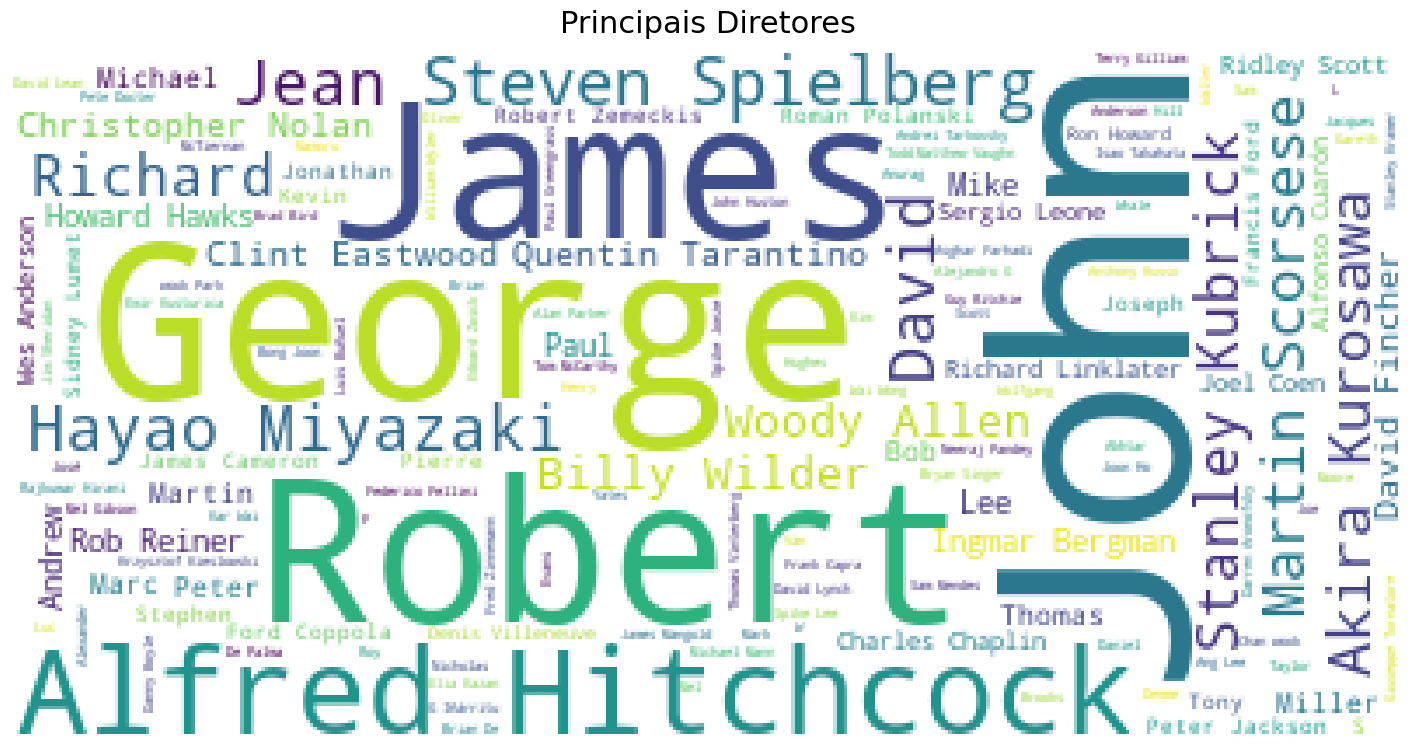

In [100]:
#Nuvem de palavras de diretores

wc.generate(' '.join(df_analise['Director']))
plt.figure(figsize=(18,10))
plt.title('Principais Diretores', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

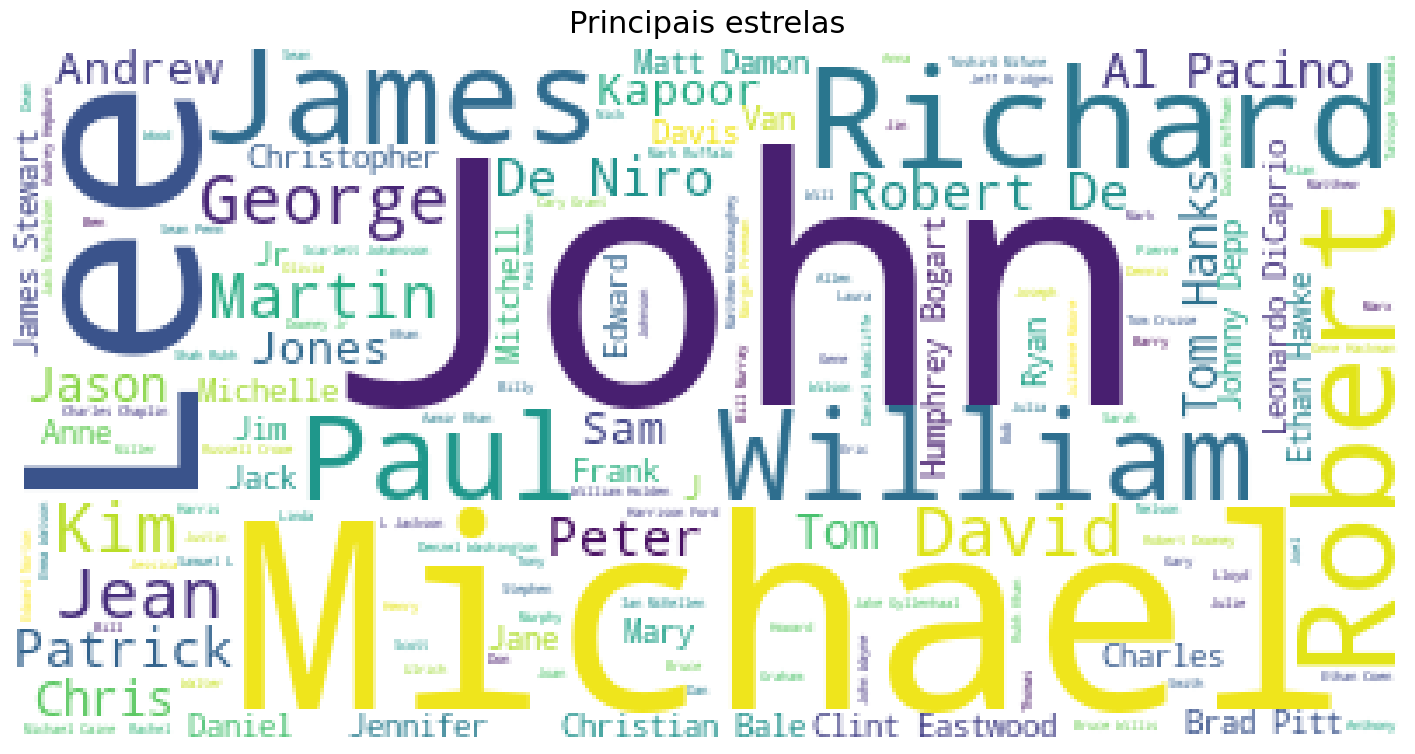

In [101]:
#Nuvem de palavras das estrelas

wc.generate(' '.join(stars))
plt.figure(figsize=(18,10))
plt.title('Principais estrelas', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

Por fim, podemos medir as palavras mais repetidas na coluna 'Overview' de cada gênero. Para isso vamos tratar a coluna Overview_Clean com TF-IDF para que a máquina seja capaz de processar as palavras, e criar uma função que categoriza as palavras mais importantes em cada gênero.

In [102]:
# Definir o tfid como vetorizador
vectorizer = TfidfVectorizer(max_features=5000)  

# Definir as variáveis e aplicar o vetorizador
corpus = df_analise["Overview_clean"].fillna("")
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_nomes = vectorizer.get_feature_names_out()

In [103]:
#Função para definir a importância das palavras de acordo com o gênero
def top_words_for_genre(genre, n=10):
    mask = (df_analise[genre]  == 1).to_numpy()
    genre_tfidf = tfidf_matrix[mask]
    pontuacao_media = genre_tfidf.mean(axis=0).A1
    top_idx = pontuacao_media.argsort()[-n:][::-1]
    return [(feature_nomes[i], pontuacao_media[i]) for i in top_idx]

for g in genre_features:
    print(f"\nTop palavras em {g}:")
    for word, score in top_words_for_genre(g, 5):
        print(f"{word}: {score:.4f}")


Top palavras em Action:
must: 0.0185
one: 0.0152
in: 0.0150
forc: 0.0147
assassin: 0.0147

Top palavras em Adventure:
world: 0.0224
young: 0.0193
the: 0.0178
set: 0.0157
in: 0.0156

Top palavras em Animation:
young: 0.0362
girl: 0.0347
boy: 0.0254
world: 0.0247
when: 0.0242

Top palavras em Biography:
the: 0.0503
stori: 0.0421
life: 0.0263
american: 0.0232
man: 0.0187

Top palavras em Comedy:
young: 0.0210
two: 0.0174
get: 0.0165
man: 0.0159
live: 0.0156

Top palavras em Crime:
murder: 0.0271
two: 0.0209
an: 0.0197
crime: 0.0197
polic: 0.0187

Top palavras em Drama:
man: 0.0194
young: 0.0194
life: 0.0188
the: 0.0176
find: 0.0166

Top palavras em Family:
young: 0.0352
home: 0.0288
boy: 0.0286
girl: 0.0268
famili: 0.0267

Top palavras em Fantasy:
world: 0.0291
magic: 0.0240
man: 0.0233
mysteri: 0.0219
find: 0.0214

Top palavras em Film-Noir:
murder: 0.0637
detect: 0.0424
privat: 0.0380
insur: 0.0354
screenwrit: 0.0340

Top palavras em History:
war: 0.0396
the: 0.0377
king: 0.0282
german

## Perguntas 2

Com esses dados, podemos responder as perguntas 2- a, b e c.

Começando pela pergunta 2-a:

### Qual filme você recomendaria para uma pessoa que você não conhece?

Para indicar um filme para uma pessoa que não conheço os gostos, usaria as variáveis mais relacionadas com a nota do IMDB, de acordo com as correlações calculadas. Elas seriam o No_of_votes, Meta_score e Runtime e a própria IMDB_Rating. Além disso, poderia priorizar um gênero com maior correlação com o faturamento, como Ação, Aventura, Animação ou Sci-fi.

In [104]:
media_votos = df_analise['No_of_Votes'].mean()
media_meta_score = df_analise['Meta_score'].mean()
media_imdb = df_analise['IMDB_Rating'].mean()
media_runtime = df_analise['Runtime_min'].mean()

df_recomendacao = df_analise[(df_analise['No_of_Votes'] > media_votos) & (df_analise['Meta_score'] > media_meta_score) & (df_analise['IMDB_Rating'] > media_imdb) & (df_analise['Runtime_min'] > media_runtime)]

df_recomendacao.head()

,Series_Title,Released_Year,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,...,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,UA,Unrated,Overview_clean
0,The Godfather,1972,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,...,0,0,0,0,0,0,0,0,0,an organ crime dynasti age patriarch transfer ...
1,The Dark Knight,2008,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,...,0,0,0,0,0,0,0,1,0,when menac known joker wreak havoc chao peopl ...
2,The Godfather: Part II,1974,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,...,0,0,0,0,0,0,0,0,0,the earli life career vito corleon 1920s new y...
4,The Lord of the Rings: The Return of the King,2003,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,...,0,0,0,0,0,0,1,0,0,gandalf aragorn lead world men sauron armi dra...
5,Pulp Fiction,1994,8.9,"The lives of two mob hitmen, a boxer, a gangst...",94.0,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,...,0,0,0,0,0,0,0,0,0,"the live two mob hitmen, boxer, gangster wife,..."


Dos filmes dessa lista, eu não recomendaria The Godfather: Part II e The Lord of the Rings: The Return of the King, pois são continuações de outros filmes que eu não saberia se a pessoa assistiu.
Vamos adicionar mais um filtro, onde o filme deve ser de Aventura, um dos gêneros mais relevantes da análise anterior.

In [105]:
df_recomendacao = df_recomendacao[df_recomendacao['Adventure'] == 1]
df_recomendacao.head()

,Series_Title,Released_Year,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,...,PG-13,Passed,R,TV-14,TV-MA,TV-PG,U,UA,Unrated,Overview_clean
4,The Lord of the Rings: The Return of the King,2003,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,...,0,0,0,0,0,0,1,0,0,gandalf aragorn lead world men sauron armi dra...
9,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,A meek Hobbit from the Shire and eight compani...,92.0,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,...,0,0,0,0,0,0,1,0,0,a meek hobbit shire eight companion set journe...
12,The Lord of the Rings: The Two Towers,2002,8.7,While Frodo and Sam edge closer to Mordor with...,87.0,Peter Jackson,Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom,...,0,0,0,0,0,0,0,1,0,while frodo sam edg closer mordor help shifti ...
15,Star Wars: Episode V - The Empire Strikes Back,1980,8.7,After the Rebels are brutally overpowered by t...,82.0,Irvin Kershner,Mark Hamill,Harrison Ford,Carrie Fisher,Billy Dee Williams,...,0,0,0,0,0,0,0,1,0,after rebel brutal overpow empir ice planet ho...
22,Sen to Chihiro no kamikakushi,2001,8.6,"During her family's move to the suburbs, a sul...",96.0,Hayao Miyazaki,Daveigh Chase,Suzanne Pleshette,Miyu Irino,Rumi Hiiragi,...,0,0,0,0,0,0,1,0,0,"dure famili move suburbs, sullen 10-year-old g..."


Com esse resultado, eu recomendaria o filme The Dark Knight, baseada nas métricas analisadas.

### Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Podemos responder isso com base nas análises de correlação que fizemos anteriormente. As métricas com maior correlação com o faturamento de um filme são **No_of_Votes**, **Meta_Score**, **Runtime** e os gêneros **Aventura** e **Ação**

### Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Podemos medir a relação das palavras de overview com o gênero dos filmes, quais são as palavras mais utilizadas e mesmo a relação entre o overview e diretores. Dito isso, podemos inferir o gênero dos filmes a partir das palavras mais populares da coluna overview por gênero, como exploramos mais cedo.

## Modelos Preditivos

In [106]:
#Definindo possíveis features

num_cols = ['Released_Year', 'Runtime_min', 'Meta_score', 'No_of_Votes', 'Gross']
cat_cols = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']
text_cols = 'Overview_clean'
binary_cols = ['Action','Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War',
       'Western', '16', 'A', 'Approved', 'G', 'GP', 'PG', 'PG-13', 'Passed',
       'R', 'TV-14', 'TV-MA', 'TV-PG', 'U', 'UA', 'Unrated']
num_features = num_cols + binary_cols

In [107]:
#Definindo e treinando as features e target para os modelos

X = df_analise[num_features + cat_cols + [text_cols]]
y = df_analise['IMDB_Rating']

#Separando variáveis de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [108]:
#Pipeline numérico 
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Pipeline de texto
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, max_df=0.8))
])

#Pré-processamento: combinar todas as features
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', CountEncoder(), cat_cols),
    ('text', text_transformer, text_cols)
], remainder='passthrough')

### Huber Regressor

In [109]:
#Processamento dos dados em um Huber Regressor
huber_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HuberRegressor())
])

huber_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Released_Year',
                                                   'Runtime_min', 'Meta_score',
                                                   'No_of_Votes', 'Gross']),
                                                 ('cat',
                                                  CountEncoder(combine_min_nan_groups=True),
                                                  ['Director', 'Star1', 'Star2',
                                                   'Star3', 'Star4']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.8,
                                                                                   max_features=1000))]),
                                                  'Overview_clean')])),
                ('regressor', HuberRegressor())])

In [110]:
y_pred = huber_model.predict(X_test)

# Métricas de Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

#Printar Resultados
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.18698542039297913
MSE: 0.0546484545046429
RMSE: 0.23377008898625784
R2: 0.16750267344094083


### Random Forest

In [111]:
#Pipeline Random Forest
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

random_forest_pipeline.fit(X_train, y_train)

y_rm_pred = random_forest_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_rm_pred)
mse = mean_squared_error(y_test, y_rm_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_rm_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.15329749999999995
MSE: 0.03954390125000005
RMSE: 0.19885648405319864
R2: 0.397600675613917


### Gradient Boosting

In [112]:
gradient_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gradient_pipeline.fit(X_train, y_train)

y_gb_pred = gradient_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_gb_pred)
mse = mean_squared_error(y_test, y_gb_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_gb_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.15952159988601275
MSE: 0.040312105958247406
RMSE: 0.20077874877149576
R2: 0.3858980872852449


### XGBoost

In [113]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.1556802158355713
MSE: 0.04051308156923325
RMSE: 0.20127861677096565
R2: 0.38283648819034133


### Catboost

In [114]:
cb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        verbose=0
    ))
])

cb_pipeline.fit(X_train, y_train)

y_pred_cb = cb_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_cb)
mse = mean_squared_error(y_test, y_pred_cb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_cb)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.1556574248160282
MSE: 0.03965927990113979
RMSE: 0.1991463780768804
R2: 0.39584303361861295


Com a experimentação de diferente modelos preditivos, podemos responder a terceira pergunta:

### Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Estamos lidando com um problema de regressão, já que a saída desejada não é uma resposta binária (como sim ou não, certo ou errado, aprovado ou desaprovado), mas uma estimativa de valor.

Para prever os dados, usei todos os dados do dataframe, mas tive que tratar as colunas categóricas (como Diretores, Gênero e Overview) para que os modelos fossem capazes de processá-los. Para as colunas 'Genre' e 'Certificate', usei o OneHotEncoding. Elas eram colunas categóricas com poucos valores, portanto aumentar a quantidade de colunas do dataframe para classificá-las não seria um grande problema.

Para as categorias categóricas com maior granularidade 'Director', 'Star1', 'Star2', 'Star3', 'Star4' decidi tratar diretamente no pré-porcessamento, fazendo uso do TF-IDF. Ele transforma as palavras em vetores numéricos, baseado em um cálculo de importância de cada palavra e mantendo as mais relevantes. Essa foi uma forma eficaz de manter features que poderiam ser importantes sem perder o peso delas.

Para medir a performance, escolhi as métricas:

- **MAE (erro médio absoluto):** mede o erro médio do meu alvo (Nota do IMDB), quanto menor, melhor
- **RMSE (raiz do erro quadrático médio):** penaliza mais os erros grandes, consigo usar para medir e minimizar outliers. Considerando a grande variação numérica dos dados, foi importante ter essa preocupação.
- **R² (coeficiente de determinação):** o quanto da variabilidade dos dados que o modelo consegue explicar. Considerando que o sucesso de um filme pode ter muitas variáveis, é importante que o modelo seja capaz de mitigar o quanto dessa variabilidade pertence ao acaso.

Ao criar diferentes modelos e avaliar suas perfomances, escolhi a Random Forest para esse desafio. A relação entre as features e a nota do IMDB não são lineares (por isso os valores de correlação eram tão baixos nas análises iniciais), então os modelos de Árvore tiveram uma melhor performance. A Random Forest foi o modelo com o menor MAE e o maior R², apesar de exigir mais performance do que os outros modelos. Ela lida bem com os padrões não lineares e não é tão sensível a valores discrepantes, o que a torna uma ótima candidata. Em contrapartida, ela é mais pesada e corre mais risco de memorizar dados irrelevantes, erros na hora de escolher as features podem comprometer grandemente seu resultado, mas, para esse cenário, os prós vencem os contras.

In [115]:
with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(random_forest_pipeline, f)

### Supondo um filme com as seguintes características:

> {'Series_Title': 'The Shawshank Redemption',<br>
 'Released_Year': '1994',<br>
 'Certificate': 'A',<br>
 'Runtime': '142 min',<br>
 'Genre': 'Drama',<br>
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',<br>
 'Meta_score': 80.0,<br>
 'Director': 'Frank Darabont',<br>
 'Star1': 'Tim Robbins',<br>
 'Star2': 'Morgan Freeman',<br>
 'Star3': 'Bob Gunton',<br>
 'Star4': 'William Sadler',<br>
 'No_of_Votes': 2343110,<br>
 'Gross': '28,341,469'}<br>



Qual seria a nota do IMDB?


In [116]:
with open('rf_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In [117]:
filme_novo = pd.DataFrame([{
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': 1994,
    'Certificate': 'A',
    'Runtime_min': 142,
    'Genre': 'Drama',
    'Overview_clean': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': 28341469 

}])

filme_novo.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime_min', 'Genre',
       'Overview_clean', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [118]:
# É preciso ajustar o novo dataframe para que ele tenha as mesmas colunas do pipeline
GENRES = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
          'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 
          'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 
          'Thriller', 'War', 'Western']

def encode_genre(genre_str):
    return {g: int(g == genre_str) for g in GENRES}

CERTIFICATES = ['16', 'A', 'Approved', 'G', 'GP', 'PG', 'PG-13', 'Passed', 
                'R', 'TV-14', 'TV-MA', 'TV-PG', 'U', 'UA', 'Unrated']

def encode_certificate(cert_str):
    return {c: int(c == cert_str) for c in CERTIFICATES}

filme_novo = pd.concat([filme_novo, pd.DataFrame([encode_genre(df.loc[0, 'Genre'])])], axis=1)
filme_novo = pd.concat([filme_novo, pd.DataFrame([encode_certificate(df.loc[0, 'Certificate'])])], axis=1)
filme_novo = filme_novo.drop(columns=['Genre', 'Certificate'])

In [119]:
pred = loaded_pipeline.predict(filme_novo)
print(f"Predicted IMDB Rating: {pred[0]:.2f}")

Predicted IMDB Rating: 8.75
